# PJM电力负荷数据探索
## 任务目标
1. 加载并了解PJM电力负荷数据集
2. 绘制日/周负荷曲线
3. 分析数据周期性和异常值

In [6]:
# 导入库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
plt.style.use('seaborn')
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题
%matplotlib inline

In [7]:
# 2.1.1 数据导入 - 使用pandas读取CSV文件
print("数据来源: PJM_Load_hourly.csv")
print("主要字段说明:")
print("- Datetime: 时间戳 (每小时)")
print("- PJM_Load_MW: PJM电网总负荷 (兆瓦)")

df = pd.read_csv('../data/raw/PJM_Load_hourly.csv', parse_dates=['Datetime'])
df = df.set_index('Datetime').sort_index()

# 统一列名
if 'PJM_Load_MW' in df.columns:
    df = df.rename(columns={'PJM_Load_MW': 'PJM_Load'})

# 2.1.2 数据基本信息
print("\n=== 数据基本信息 ===")
print(f"时间范围: {df.index.min()} 到 {df.index.max()}")
print(f"总数据点数: {len(df)}")
print(f"采样频率: 每小时")

print("\n数据类型和缺失值:")
print(df.info())

print("\n统计描述:")
print(df.describe())

# 展示前5行数据
print("\n前5行数据:")
df.head()

数据来源: PJM_Load_hourly.csv
主要字段说明:
- Datetime: 时间戳 (每小时)
- PJM_Load_MW: PJM电网总负荷 (兆瓦)

=== 数据基本信息 ===
时间范围: 1998-04-01 01:00:00 到 2002-01-01 00:00:00
总数据点数: 32896
采样频率: 每小时

数据类型和缺失值:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32896 entries, 1998-04-01 01:00:00 to 2002-01-01 00:00:00
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   PJM_Load  32896 non-null  float64
dtypes: float64(1)
memory usage: 514.0 KB
None

统计描述:
           PJM_Load
count  32896.000000
mean   29766.427408
std     5849.769954
min    17461.000000
25%    25473.000000
50%    29655.000000
75%    33073.250000
max    54030.000000

前5行数据:


,PJM_Load
Datetime,
1998-04-01 01:00:00,22259.0
1998-04-01 02:00:00,21244.0
1998-04-01 03:00:00,20651.0
1998-04-01 04:00:00,20421.0
1998-04-01 05:00:00,20713.0


load_data类型: <class 'pandas.core.frame.DataFrame'>
load_data形状: (32896, 1)
load_data索引类型: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
load_data列名: Index(['PJM_Load'], dtype='object')
最近一周数据范围: 2001-12-26 00:00:00 到 2002-01-01 00:00:00
最近一周数据点数: 145
日期 2001-12-26 的数据点数: 24
日期 2001-12-27 的数据点数: 24
日期 2001-12-28 的数据点数: 24
日期 2001-12-29 的数据点数: 24
日期 2001-12-30 的数据点数: 24
日期 2001-12-31 的数据点数: 24
日期 2002-01-01 的数据点数: 1


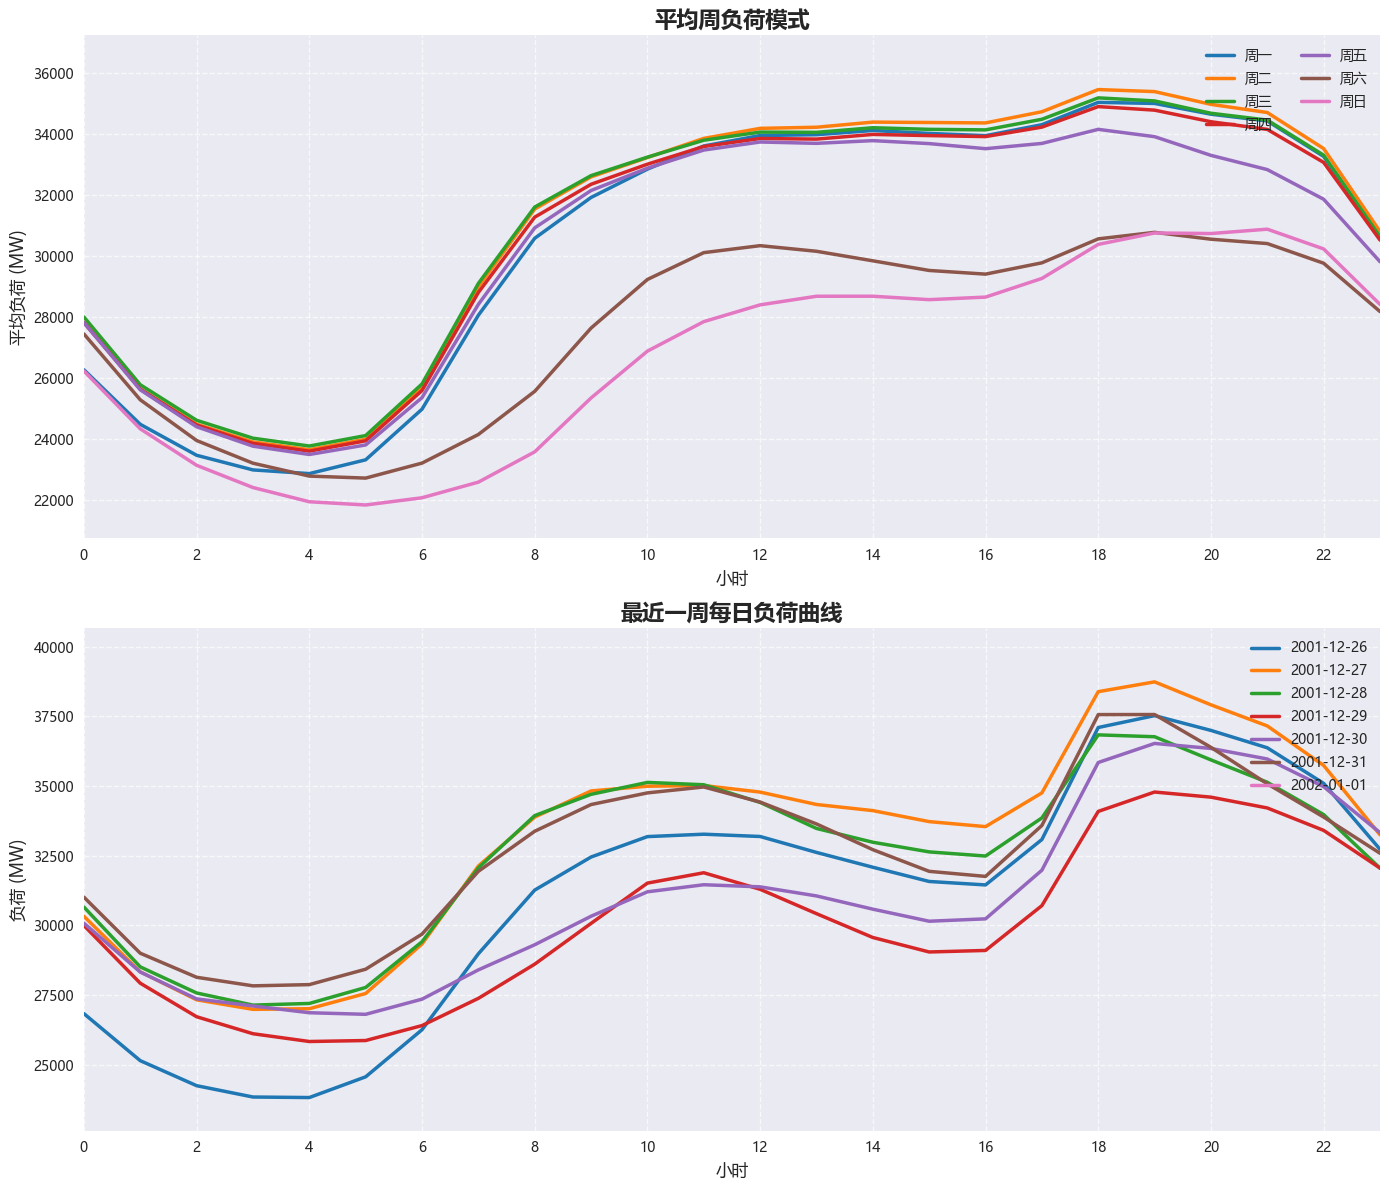

In [8]:
# 提取负荷数据
from datetime import timedelta


load_data = df
print(f"load_data类型: {type(load_data)}")
print(f"load_data形状: {load_data.shape if hasattr(load_data, 'shape') else 'N/A'}")
print(f"load_data索引类型: {type(load_data.index)}")
print(f"load_data列名: {load_data.columns}")

# 创建图形
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# 第一张图: 平均周负荷模式
try:
    # 提取负荷列作为Series
    load_series = load_data['PJM_Load_MW'] if 'PJM_Load_MW' in load_data.columns else load_data.iloc[:, 0]
    
    # 创建DataFrame
    load_df = pd.DataFrame({
        'load': load_series.values,
        'hour': load_series.index.hour,
        'dayofweek': load_series.index.dayofweek
    }, index=load_series.index)
    
    # 按星期几和小时分组计算平均值
    weekly_pattern = load_df.groupby(['dayofweek', 'hour']).mean().reset_index()

    # 为每个星期几绘制曲线
    weekdays = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

    for day in range(7):
        day_data = weekly_pattern[weekly_pattern['dayofweek'] == day]
        ax1.plot(day_data['hour'].to_numpy(), day_data['load'].to_numpy(), 
                label=weekdays[day], color=colors[day], linewidth=2.5)

    ax1.set_title('平均周负荷模式', fontsize=16, fontweight='bold')
    ax1.set_xlabel('小时', fontsize=12)
    ax1.set_ylabel('平均负荷 (MW)', fontsize=12)
    ax1.set_xlim(0, 23)
    ax1.set_xticks(range(0, 24, 2))
    ax1.grid(True, linestyle='--', alpha=0.7)
    ax1.legend(loc='upper right', ncol=2, fontsize=10)

    # 设置y轴范围，根据数据调整
    y_min = weekly_pattern['load'].min() * 0.95
    y_max = weekly_pattern['load'].max() * 1.05
    ax1.set_ylim(y_min, y_max)

except Exception as e:
    print(f"创建平均周负荷模式图时出错: {e}")
    import traceback
    traceback.print_exc()

# 第二张图: 最近一周每日负荷曲线
try:
    # 提取负荷列作为Series
    load_series = load_data['PJM_Load_MW'] if 'PJM_Load_MW' in load_data.columns else load_data.iloc[:, 0]
    
    # 获取最近7天的数据
    end_date = load_series.index.max()
    start_date = end_date - timedelta(days=6)  # 获取最近7天
    last_week_data = load_series[(load_series.index >= start_date) & (load_series.index <= end_date)]
    
    print(f"最近一周数据范围: {start_date} 到 {end_date}")
    print(f"最近一周数据点数: {len(last_week_data)}")

    # 为每一天绘制曲线
    dates = pd.date_range(start=start_date, end=end_date)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

    for i, date in enumerate(dates):
        day_mask = (last_week_data.index.date == date.date())
        day_data = last_week_data[day_mask]
        print(f"日期 {date.date()} 的数据点数: {len(day_data)}")
        
        if not day_data.empty:
            # 按小时分组并计算平均值
            hourly_data = day_data.groupby(day_data.index.hour).mean()
            ax2.plot(hourly_data.index.to_numpy(), hourly_data.values, 
                    label=date.strftime('%Y-%m-%d'), color=colors[i], linewidth=2.5)

    ax2.set_title('最近一周每日负荷曲线', fontsize=16, fontweight='bold')
    ax2.set_xlabel('小时', fontsize=12)
    ax2.set_ylabel('负荷 (MW)', fontsize=12)
    ax2.set_xlim(0, 23)
    ax2.set_xticks(range(0, 24, 2))
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.legend(loc='upper right', fontsize=10)

    # 设置y轴范围，根据数据调整
    if not last_week_data.empty:
        y_min2 = last_week_data.min() * 0.95
        y_max2 = last_week_data.max() * 1.05
        ax2.set_ylim(float(y_min2), float(y_max2))  # 确保转换为标量值

except Exception as e:
    print(f"创建最近一周每日负荷曲线图时出错: {e}")
    import traceback
    traceback.print_exc()

plt.tight_layout()
plt.show()



=== 可视化分析 ===


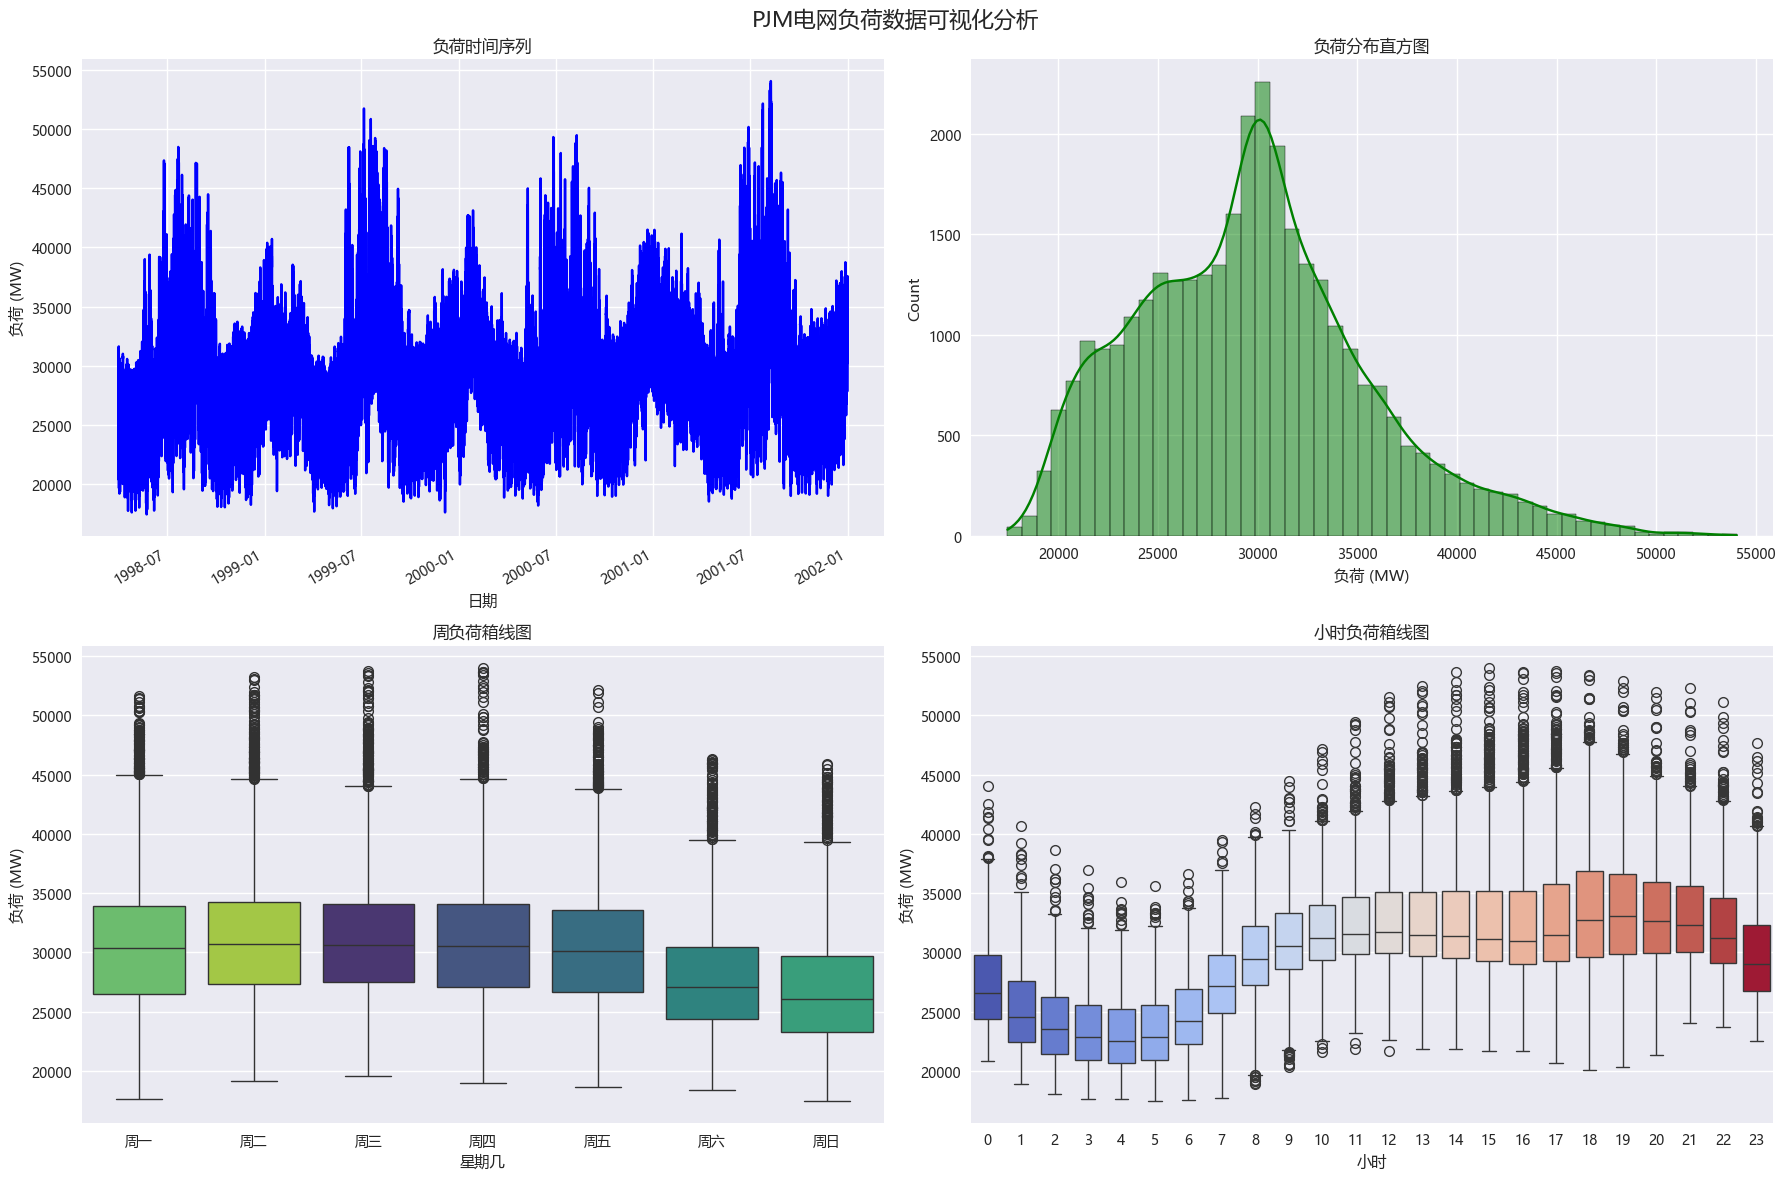


=== 数据质量分析 ===

数据完整性检查:
              缺失值数量  缺失值比例
PJM_Load          0    0.0
dayofweek         0    0.0
weekday_name      0    0.0
hour              0    0.0

异常值检测方法: 滑动窗口(7天) + 3σ原则
检测到异常值数量: 5
异常值比例: 0.02%


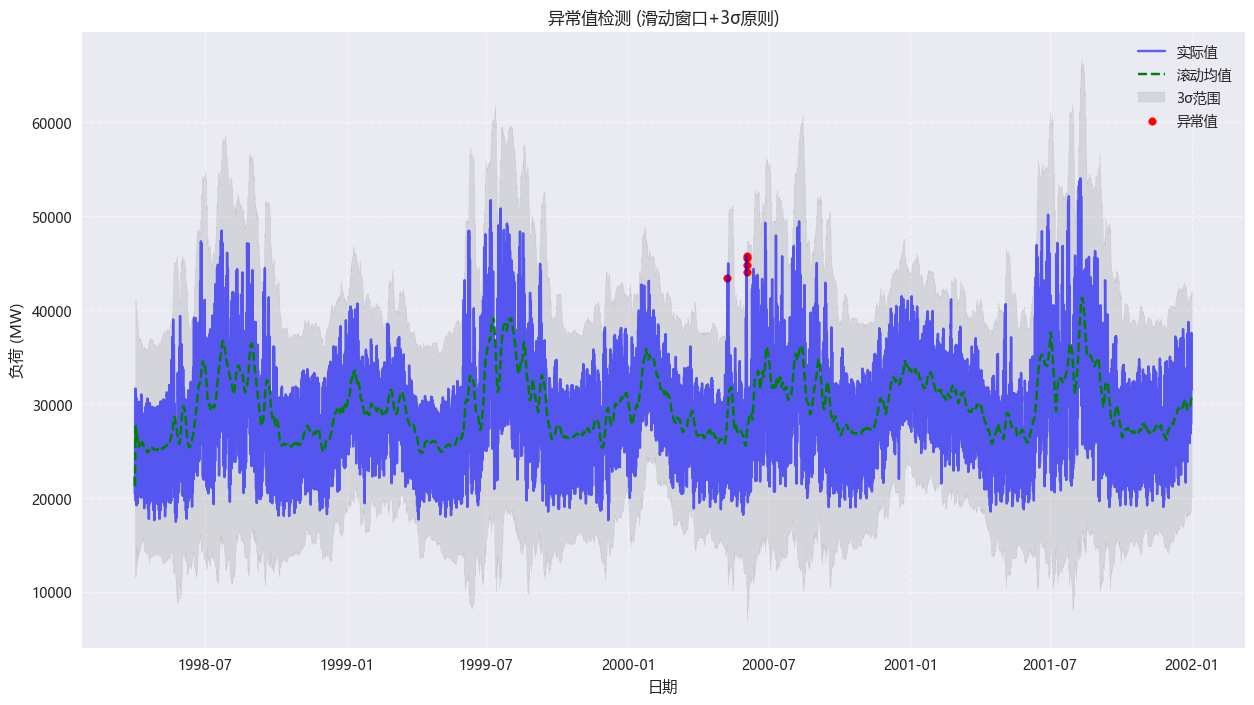


异常值处理方法: 使用滚动均值替换异常值


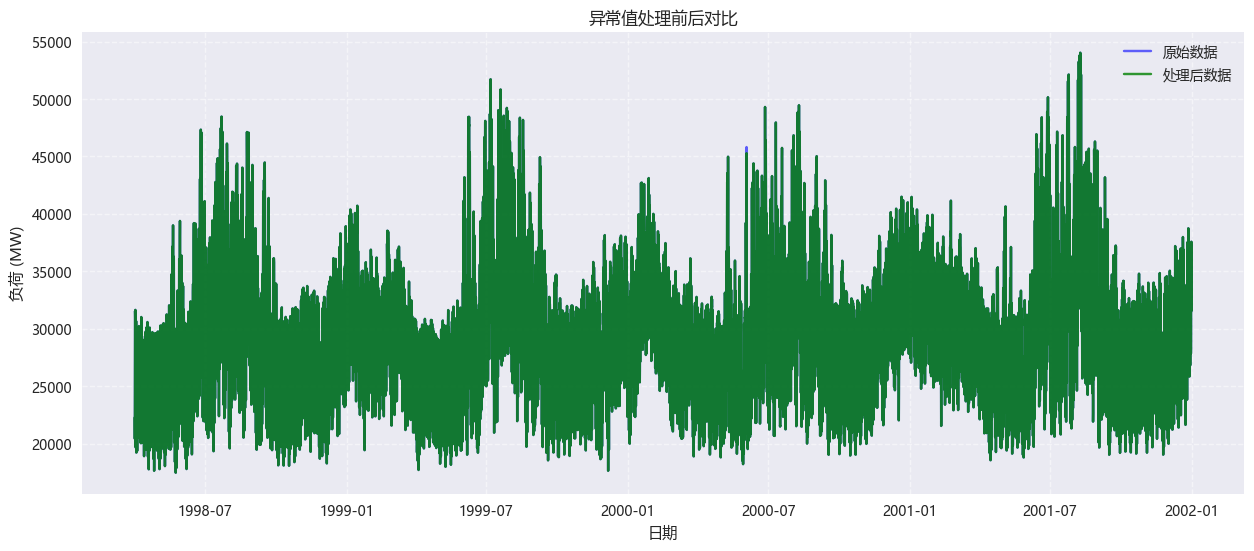


已保存处理后的数据到: data/processed/PJM_Load_processed.csv


In [9]:
# 2.1.3 可视化分析
import os


print("\n=== 可视化分析 ===")

# 创建2x2的子图布局
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('PJM电网负荷数据可视化分析', fontsize=16)

# 1. 负荷时间序列
df['PJM_Load'].plot(ax=axes[0, 0], title='负荷时间序列', color='blue')
axes[0, 0].set_xlabel('日期')
axes[0, 0].set_ylabel('负荷 (MW)')

# 2. 负荷分布直方图
sns.histplot(df['PJM_Load'], bins=50, ax=axes[0, 1], kde=True, color='green')
axes[0, 1].set_title('负荷分布直方图')
axes[0, 1].set_xlabel('负荷 (MW)')

# 3. 周负荷箱线图
df['dayofweek'] = df.index.dayofweek
weekday_names = ['周一', '周二', '周三', '周四', '周五', '周六', '周日']
df['weekday_name'] = df['dayofweek'].apply(lambda x: weekday_names[x])
sns.boxplot(x='weekday_name', y='PJM_Load', data=df, ax=axes[1, 0], 
            hue='weekday_name',  # 添加hue参数，与x相同
            dodge=False,         # 避免分组间距
            legend=False,        # 不显示图例
            order=weekday_names, palette='viridis')
axes[1, 0].set_title('周负荷箱线图')
axes[1, 0].set_xlabel('星期几')
axes[1, 0].set_ylabel('负荷 (MW)')

# 4. 小时负荷箱线图
df['hour'] = df.index.hour
sns.boxplot(x='hour', y='PJM_Load', data=df, ax=axes[1, 1], 
            hue='hour',          # 添加hue参数，与x相同
            dodge=False,         # 避免分组间距
            legend=False,        # 不显示图例
            palette='coolwarm')
axes[1, 1].set_title('小时负荷箱线图')
axes[1, 1].set_xlabel('小时')
axes[1, 1].set_ylabel('负荷 (MW)')

plt.tight_layout()
plt.show()

# 2.2 数据质量分析与异常值处理
print("\n=== 数据质量分析 ===")

# 2.2.1 数据完整性验证
print("\n数据完整性检查:")
missing_check = pd.DataFrame({
    '缺失值数量': df.isnull().sum(),
    '缺失值比例': df.isnull().mean().round(4) * 100
})
print(missing_check)

# 2.2.2 异常值检测
print("\n异常值检测方法: 滑动窗口(7天) + 3σ原则")

def detect_anomalies(df, window=24*7, n_sigma=3):
    """使用滑动窗口+3σ原则检测异常值"""
    rolling = df.rolling(window=window, min_periods=1)
    mean = rolling.mean()
    std = rolling.std()
    anomalies = (df - mean).abs() > n_sigma * std
    return anomalies, mean, std

anomalies, rolling_mean, rolling_std = detect_anomalies(df[['PJM_Load']])
print(f"检测到异常值数量: {anomalies['PJM_Load'].sum()}")
print(f"异常值比例: {anomalies['PJM_Load'].mean()*100:.2f}%")

# 可视化异常值
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['PJM_Load'], label='实际值', color='blue', alpha=0.6)
plt.plot(df.index, rolling_mean['PJM_Load'], label='滚动均值', color='green', linestyle='--')
plt.fill_between(df.index, 
                 rolling_mean['PJM_Load'] - 3*rolling_std['PJM_Load'], 
                 rolling_mean['PJM_Load'] + 3*rolling_std['PJM_Load'], 
                 color='gray', alpha=0.2, label='3σ范围')
plt.scatter(df[anomalies['PJM_Load']].index, 
            df[anomalies['PJM_Load']]['PJM_Load'], 
            color='red', label='异常值', s=30)
plt.title('异常值检测 (滑动窗口+3σ原则)')
plt.xlabel('日期')
plt.ylabel('负荷 (MW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 2.2.3 异常值处理
print("\n异常值处理方法: 使用滚动均值替换异常值")

# 创建处理后的数据副本
df_processed = df.copy()
df_processed['PJM_Load_processed'] = df['PJM_Load']
df_processed.loc[anomalies['PJM_Load'], 'PJM_Load_processed'] = rolling_mean['PJM_Load']

# 可视化处理前后对比
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['PJM_Load'], label='原始数据', color='blue', alpha=0.6)
plt.plot(df_processed.index, df_processed['PJM_Load_processed'], 
         label='处理后数据', color='green', alpha=0.8)
plt.title('异常值处理前后对比')
plt.xlabel('日期')
plt.ylabel('负荷 (MW)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 保存处理后的数据
if not os.path.exists('../data/processed'):
    os.makedirs('../data/processed')
df_processed.to_csv('../data/processed/PJM_Load_processed.csv')
print("\n已保存处理后的数据到: data/processed/PJM_Load_processed.csv")

In [ ]:
"""
特征工程模块
实现四种不同的特征工程方案
"""
import pandas as pd
import numpy as np
from datetime import timedelta
from pandas.tseries.holiday import USFederalHolidayCalendar

class FeatureEngineer:
    def __init__(self, data_path):
        """
        初始化特征工程类
        :param data_path: 原始数据路径
        """
        self.df = pd.read_csv(data_path, parse_dates=['Datetime'])
        self.df = self.df.set_index('Datetime').sort_index()
        
        # 统一列名
        if 'PJM_Load_MW' in self.df.columns:
            self.df = self.df.rename(columns={'PJM_Load_MW': 'PJM_Load'})
        
        # 加载天气数据(如果存在)
        try:
            self.weather_df = pd.read_csv(data_path.replace('PJM_Load', 'weather'), parse_dates=['date'])
            self.weather_df = self.weather_df.set_index('date')
        except:
            self.weather_df = None
    
    def create_basic_features(self):
        """
        基础实验：仅使用时间特征
        """
        df = self.df.copy()
        
        # 时间特征
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek
        df['month'] = df.index.month
        df['dayofyear'] = df.index.dayofyear
        df['weekofyear'] = df.index.isocalendar().week
        
        return df[['PJM_Load', 'hour', 'dayofweek', 'month', 'dayofyear', 'weekofyear']]
    
    def create_enhanced_features(self):
        """
        增强实验：加入节假日特征
        """
        df = self.create_basic_features()
        
        # 添加节假日特征
        us_holidays = USFederalHolidayCalendar().holidays(start=df.index.min(), end=df.index.max())
        df['is_holiday'] = df.index.to_series().apply(lambda x: x in us_holidays).astype(int)
        
        return df
    
    def create_comprehensive_features(self, window_size=24*7):
        """
        综合实验：加入滑动窗口和天气特征
        """
        df = self.create_enhanced_features()
        
        # 滑动窗口特征
        df['rolling_mean_24h'] = df['PJM_Load'].rolling(window=24, min_periods=1).mean()
        df['rolling_mean_7d'] = df['PJM_Load'].rolling(window=window_size, min_periods=1).mean()
        df['rolling_std_7d'] = df['PJM_Load'].rolling(window=window_size, min_periods=1).std()
        
        # 天气特征(如果可用)
        if self.weather_df is not None:
            df = df.join(self.weather_df, how='left')
            df['temp_diff'] = df['temp_max'] - df['temp_min']
        
        return df
    
    def create_ablation_features(self):
        """
        消融实验：去掉节假日特征
        """
        df = self.create_enhanced_features()
        return df.drop(columns=['is_holiday'])
    
    def create_all_features(self):
        """加强版特征工程 V2"""
        df = self.df.copy()
        
        # 1. 基础与高级时间特征
        df['hour'] = df.index.hour
        df['dayofweek'] = df.index.dayofweek
        df['month'] = df.index.month
        df['quarter'] = df.index.quarter
        df['dayofyear'] = df.index.dayofyear
        
        # 周期性编码
        df['hour_sin'] = np.sin(df['hour'] * (2 * np.pi / 24))
        df['hour_cos'] = np.cos(df['hour'] * (2 * np.pi / 24))
        df['doy_sin'] = np.sin(df['dayofyear'] * (2 * np.pi / 365))
        df['doy_cos'] = np.cos(df['dayofyear'] * (2 * np.pi / 365))
        
        # 时段特征
        df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
        df['is_night'] = df['hour'].between(0, 5).astype(int)
        df['is_morning_peak'] = df['hour'].between(6, 9).astype(int)
        df['is_evening_peak'] = df['hour'].between(18, 21).astype(int)
        
        # 2. 节假日特征 - 使用更稳健的方法
        cal = USFederalHolidayCalendar()
        holidays = cal.holidays(start=df.index.min(), end=df.index.max())
        
        # 创建日期列表
        holiday_dates = [d.date() for d in holidays]
        
        # 使用列表推导式创建节假日标志
        df_dates = df.index.date
        holiday_flags = [1 if date in holiday_dates else 0 for date in df_dates]
        df['is_holiday'] = holiday_flags
        
        # 3. 滞后特征
        for lag in [1, 2, 3, 24, 48, 168]: # 增加了48小时(2天)的滞后
            df[f'lag_{lag}'] = df['PJM_Load'].shift(lag)
        
        # 4. 滚动统计特征
        df['rolling_24h_mean'] = df['PJM_Load'].rolling(24).mean()
        df['rolling_24h_std'] = df['PJM_Load'].rolling(24).std() # 新增标准差
        df['rolling_7d_mean'] = df['PJM_Load'].rolling(168).mean()
        
        # 5. 差分和比值特征
        df['diff_1h'] = df['PJM_Load'].diff(1) # 当前值与1小时前的差值
        df['diff_24h'] = df['PJM_Load'].diff(24) # 当前值与24小时前的差值
        df['ratio_24h'] = df['PJM_Load'] / df['PJM_Load'].shift(24) # 当前值/24小时前值
        
        df.drop(columns=['weekday_name'], inplace=True) # 删除冗余列

        # 删除因特征工程产生的初始NaN行
        return df.dropna()
    
    def save_datasets(self, output_dir):
        """
        保存五种特征数据集
        """
        basic = self.create_basic_features()
        enhanced = self.create_enhanced_features()
        comprehensive = self.create_comprehensive_features()
        ablation = self.create_ablation_features()
        all_features = self.create_all_features()
        
        basic.to_csv(f"{output_dir}/basic_features.csv")
        enhanced.to_csv(f"{output_dir}/enhanced_features.csv")
        comprehensive.to_csv(f"{output_dir}/comprehensive_features.csv")
        ablation.to_csv(f"{output_dir}/ablation_features.csv")
        all_features.to_csv(f"{output_dir}/all_features.csv")
        
        print(f"已保存五种特征数据集到: {output_dir}")


# 输入输出路径
input_path = "../data/processed/PJM_Load_processed.csv"
output_dir = "../data/processed"

# 创建输出目录
os.makedirs(output_dir, exist_ok=True)

# 特征工程处理
fe = FeatureEngineer(input_path)
fe.save_datasets(output_dir)

print("数据预处理完成，已生成五种特征数据集")

已保存五种特征数据集到: ../data/processed
数据预处理完成，已生成五种特征数据集
